# Multilayer Network Analysis in Systems Biology

## Case Study: Multi-Omic Disease Module Discovery
 
 This notebook demonstrates a complete multilayer network workflow modeling
 a disease system across multiple biological layers:
 
 - **Layer 1: PPI (Protein-Protein Interaction)**
 - **Layer 2: Metabolic reactions**
 - **Layer 3: Gene regulatory network (TF → target)**
 - **Layer 4: Disease phenotype associations**
 
 We analyze how perturbations propagate across layers and identify
 cross-layer disease modules using spectral methods.

In [28]:
# ## 1. Setup

import numpy as np
import polars as pl
from scipy.sparse.linalg import eigsh
from collections import defaultdict

import sys
import os
sys.path.insert(0, os.path.abspath(".."))
from annnet.core.graph import AnnNet

# visualization:
import matplotlib.pyplot as plt


In [29]:
# ## 2. Define the Multilayer Structure
# 
# We use the Kivelä framework with a single aspect ("omic_layer") 
# containing 4 elementary layers.

G = AnnNet(directed=False)

# define the multilayer structure
G.set_aspects(
    aspects=["omic"],
    elem_layers={
        "omic": ["PPI", "metabolic", "regulatory", "phenotype"]
    }
)

print(f"Aspects: {G.aspects}")
print(f"Elementary layers: {G.elem_layers}")
print(f"All layer tuples: {list(G.iter_layers())}")

Aspects: ['omic']
Elementary layers: {'omic': ['PPI', 'metabolic', 'regulatory', 'phenotype']}
All layer tuples: [('PPI',), ('metabolic',), ('regulatory',), ('phenotype',)]


In [7]:
# ## 3. Create Biological Entities
# 
# We model 4 types of entities that can appear across layers:
# - Genes/Proteins (appear in PPI, regulatory)
# - Metabolites (appear in metabolic)
# - Enzymes (bridge PPI and metabolic)
# - Phenotypes (disease layer)

# genes/proteins involved in a hypothetical inflammatory pathway
genes = ["GENE_A", "GENE_B", "GENE_C", "GENE_D", "GENE_E", 
         "GENE_F", "GENE_G", "GENE_H", "GENE_I", "GENE_J"]

# transcription factors (subset of genes)
tfs = ["GENE_A", "GENE_C", "GENE_F"]

# enzymes (subset of genes that also participate in metabolism)
enzymes = ["GENE_B", "GENE_D", "GENE_G", "GENE_I"]

# metabolites
metabolites = ["MET_1", "MET_2", "MET_3", "MET_4", "MET_5", "MET_6"]

# phenotypes
phenotypes = ["inflammation", "cell_death", "proliferation", "immune_response"]

# add all entities as vertices with attributes
for g in genes:
    is_tf = g in tfs
    is_enzyme = g in enzymes
    G.add_vertex(g, entity_type="gene", is_tf=is_tf, is_enzyme=is_enzyme)

for m in metabolites:
    G.add_vertex(m, entity_type="metabolite")

for p in phenotypes:
    G.add_vertex(p, entity_type="phenotype")

print(f"Total vertices: {G.number_of_vertices()}")
print(G.vertices_view())

Total vertices: 20
shape: (20, 4)
┌─────────────────┬─────────────┬───────┬───────────┐
│ vertex_id       ┆ entity_type ┆ is_tf ┆ is_enzyme │
│ ---             ┆ ---         ┆ ---   ┆ ---       │
│ str             ┆ str         ┆ bool  ┆ bool      │
╞═════════════════╪═════════════╪═══════╪═══════════╡
│ GENE_A          ┆ gene        ┆ true  ┆ false     │
│ GENE_B          ┆ gene        ┆ false ┆ true      │
│ GENE_C          ┆ gene        ┆ true  ┆ false     │
│ GENE_D          ┆ gene        ┆ false ┆ true      │
│ GENE_E          ┆ gene        ┆ false ┆ false     │
│ …               ┆ …           ┆ …     ┆ …         │
│ MET_6           ┆ metabolite  ┆ null  ┆ null      │
│ inflammation    ┆ phenotype   ┆ null  ┆ null      │
│ cell_death      ┆ phenotype   ┆ null  ┆ null      │
│ proliferation   ┆ phenotype   ┆ null  ┆ null      │
│ immune_response ┆ phenotype   ┆ null  ┆ null      │
└─────────────────┴─────────────┴───────┴───────────┘


In [8]:
# ## 4. Define Layer Presence (V_M)
# 
# Not all entities exist in all layers. We explicitly declare
# which (entity, layer) pairs are valid.

# PPI layer: all genes/proteins
for g in genes:
    G.add_presence(g, ("PPI",))

# metabolic layer: metabolites + enzymes
for m in metabolites:
    G.add_presence(m, ("metabolic",))
for e in enzymes:
    G.add_presence(e, ("metabolic",))

# regulatory layer: TFs and their targets (all genes)
for g in genes:
    G.add_presence(g, ("regulatory",))

# phenotype layer: phenotypes + some key genes
for p in phenotypes:
    G.add_presence(p, ("phenotype",))
for g in ["GENE_A", "GENE_C", "GENE_F", "GENE_H"]:  # disease-associated genes
    G.add_presence(g, ("phenotype",))

print(f"Total (vertex, layer) pairs: {len(G._VM)}")

# breakdown by layer
for layer in [("PPI",), ("metabolic",), ("regulatory",), ("phenotype",)]:
    verts = G.layer_vertex_set(layer)
    print(f"  {layer[0]}: {len(verts)} entities")


Total (vertex, layer) pairs: 58
  PPI: 10 entities
  metabolic: 10 entities
  regulatory: 10 entities
  phenotype: 8 entities


In [9]:
# ## 5. Build Intra-Layer Edges
# 
# Each layer has its own interaction network.

# === PPI Layer ===
# protein-protein interactions (scale-free-ish topology)
ppi_edges = [
    ("GENE_A", "GENE_B", 0.9),  # hub A
    ("GENE_A", "GENE_C", 0.8),
    ("GENE_A", "GENE_D", 0.7),
    ("GENE_A", "GENE_E", 0.6),
    ("GENE_B", "GENE_C", 0.5),
    ("GENE_B", "GENE_F", 0.8),
    ("GENE_C", "GENE_G", 0.7),
    ("GENE_D", "GENE_H", 0.6),
    ("GENE_E", "GENE_F", 0.5),
    ("GENE_F", "GENE_G", 0.9),  # hub F
    ("GENE_F", "GENE_H", 0.7),
    ("GENE_G", "GENE_I", 0.6),
    ("GENE_H", "GENE_I", 0.8),
    ("GENE_I", "GENE_J", 0.9),
    ("GENE_J", "GENE_A", 0.4),  # closes a long-range loop
]

for src, tgt, w in ppi_edges:
    G.add_intra_edge_nl(src, tgt, ("PPI",), weight=w)

# === Metabolic Layer ===
# enzyme-metabolite and metabolite-metabolite reactions
metabolic_edges = [
    # enzyme B catalyzes MET_1 -> MET_2
    ("GENE_B", "MET_1", 1.0),
    ("GENE_B", "MET_2", 1.0),
    ("MET_1", "MET_2", 0.8),
    
    # enzyme D in pathway MET_2 -> MET_3
    ("GENE_D", "MET_2", 1.0),
    ("GENE_D", "MET_3", 1.0),
    ("MET_2", "MET_3", 0.9),
    
    # enzyme G branches to MET_4
    ("GENE_G", "MET_3", 1.0),
    ("GENE_G", "MET_4", 1.0),
    ("MET_3", "MET_4", 0.7),
    
    # enzyme I produces MET_5, MET_6
    ("GENE_I", "MET_4", 1.0),
    ("GENE_I", "MET_5", 1.0),
    ("GENE_I", "MET_6", 1.0),
    ("MET_4", "MET_5", 0.6),
    ("MET_5", "MET_6", 0.8),
]

for src, tgt, w in metabolic_edges:
    G.add_intra_edge_nl(src, tgt, ("metabolic",), weight=w)

# === Regulatory Layer ===
# TF -> target gene regulation
regulatory_edges = [
    # TF GENE_A regulates multiple targets
    ("GENE_A", "GENE_B", 0.9),
    ("GENE_A", "GENE_D", 0.8),
    ("GENE_A", "GENE_E", 0.7),
    
    # TF GENE_C regulates
    ("GENE_C", "GENE_F", 0.9),
    ("GENE_C", "GENE_G", 0.8),
    ("GENE_C", "GENE_H", 0.6),
    
    # TF GENE_F regulates (cascade)
    ("GENE_F", "GENE_I", 0.9),
    ("GENE_F", "GENE_J", 0.7),
    
    # some feedback
    ("GENE_H", "GENE_A", 0.3),  # weak negative feedback
]

for src, tgt, w in regulatory_edges:
    G.add_intra_edge_nl(src, tgt, ("regulatory",), weight=w)

# === Phenotype Layer ===
# gene-phenotype and phenotype-phenotype associations
phenotype_edges = [
    ("GENE_A", "inflammation", 0.9),
    ("GENE_A", "immune_response", 0.7),
    ("GENE_C", "cell_death", 0.8),
    ("GENE_F", "proliferation", 0.9),
    ("GENE_F", "inflammation", 0.5),
    ("GENE_H", "cell_death", 0.6),
    ("GENE_H", "immune_response", 0.4),
    
    # phenotype co-occurrence
    ("inflammation", "immune_response", 0.8),
    ("cell_death", "inflammation", 0.6),
    ("proliferation", "cell_death", 0.4),  # inverse in reality, but modeling co-occurrence
]

for src, tgt, w in phenotype_edges:
    G.add_intra_edge_nl(src, tgt, ("phenotype",), weight=w)

print(f"Total edges after intra-layer: {G.number_of_edges()}")

# count by layer
for layer in [("PPI",), ("metabolic",), ("regulatory",), ("phenotype",)]:
    edges = G.layer_edge_set(layer)
    print(f"  {layer[0]}: {len(edges)} edges")

Total edges after intra-layer: 48
  PPI: 15 edges
  metabolic: 14 edges
  regulatory: 9 edges
  phenotype: 10 edges


In [10]:
# ## 6. Build Inter-Layer Edges
# 
# These connect the same entity across different layers,
# representing the biological reality that a gene in PPI
# is the same gene in the regulatory network.

# coupling strength (tunable parameter)
omega = 1.0

# PPI <-> regulatory (all genes exist in both)
for g in genes:
    G.add_coupling_edge_nl(g, ("PPI",), ("regulatory",), weight=omega)

# PPI <-> metabolic (enzymes only)
for e in enzymes:
    G.add_coupling_edge_nl(e, ("PPI",), ("metabolic",), weight=omega)

# regulatory <-> metabolic (enzymes only)  
for e in enzymes:
    G.add_coupling_edge_nl(e, ("regulatory",), ("metabolic",), weight=omega)

# PPI <-> phenotype (disease genes)
for g in ["GENE_A", "GENE_C", "GENE_F", "GENE_H"]:
    G.add_coupling_edge_nl(g, ("PPI",), ("phenotype",), weight=omega)

# regulatory <-> phenotype (disease genes)
for g in ["GENE_A", "GENE_C", "GENE_F", "GENE_H"]:
    G.add_coupling_edge_nl(g, ("regulatory",), ("phenotype",), weight=omega)

print(f"Total edges after coupling: {G.number_of_edges()}")
print(f"Coupling edges: {len([e for e, k in G.edge_kind.items() if k == 'coupling'])}")

Total edges after coupling: 74
Coupling edges: 26


In [11]:
# ## 7. Build the Supra-Adjacency and Supra-Laplacian

# build the vertex-layer index
n_supra = G.ensure_vertex_layer_index()
print(f"Supra-graph size: {n_supra} nodes")

# get the supra-adjacency matrix
A_supra = G.supra_adjacency()
print(f"Supra-adjacency: {A_supra.shape}, nnz={A_supra.nnz}")

# get the supra-laplacian
L_supra = G.supra_laplacian(kind="comb")
print(f"Supra-Laplacian: {L_supra.shape}")

# verify row sums = 0 (Laplacian property)
row_sums = np.abs(L_supra.sum(axis=1).A.ravel())
print(f"Max row sum (should be ~0): {row_sums.max():.2e}")

Supra-graph size: 58 nodes
Supra-adjacency: (58, 58), nnz=148
Supra-Laplacian: (58, 58)
Max row sum (should be ~0): 8.88e-16


In [12]:
# ## 8. Spectral Analysis of the Multilayer Network

# compute smallest eigenvalues of the Laplacian
k = min(10, n_supra - 1)
eigenvalues, eigenvectors = eigsh(L_supra.astype(float), k=k, which="SM")

# sort by eigenvalue
idx = np.argsort(eigenvalues)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print("Smallest eigenvalues of supra-Laplacian:")
for i, ev in enumerate(eigenvalues):
    print(f"  λ_{i} = {ev:.6f}")

# algebraic connectivity
lambda2 = eigenvalues[1]
print(f"\nAlgebraic connectivity (λ₂): {lambda2:.6f}")

if lambda2 > 0.01:
    print("  → Network is well-connected across layers")
else:
    print("  → Network has weak inter-layer connectivity")

Smallest eigenvalues of supra-Laplacian:
  λ_0 = -0.000000
  λ_1 = 0.369790
  λ_2 = 0.450760
  λ_3 = 0.712021
  λ_4 = 0.752627
  λ_5 = 0.905696
  λ_6 = 0.917872
  λ_7 = 1.100199
  λ_8 = 1.223771
  λ_9 = 1.459482

Algebraic connectivity (λ₂): 0.369790
  → Network is well-connected across layers


In [13]:
# ## 9. Fiedler Vector Analysis (Community Structure)
# 
# The Fiedler vector (eigenvector of λ₂) reveals natural partitions
# in the multilayer network.

fiedler = eigenvectors[:, 1]

# map back to (vertex, layer) pairs
fiedler_mapping = {}
for i, (v, layer) in enumerate(G._row_to_nl):
    fiedler_mapping[(v, layer[0])] = fiedler[i]

# create a DataFrame for analysis
fiedler_data = [
    {"vertex": v, "layer": L, "fiedler_value": val}
    for (v, L), val in fiedler_mapping.items()
]
fiedler_df = pl.DataFrame(fiedler_data).sort("fiedler_value")

print("Fiedler vector extremes (potential cluster boundaries):")
print("\nMost negative (Cluster A):")
print(fiedler_df.head(10))
print("\nMost positive (Cluster B):")
print(fiedler_df.tail(10))

Fiedler vector extremes (potential cluster boundaries):

Most negative (Cluster A):
shape: (10, 3)
┌─────────────────┬────────────┬───────────────┐
│ vertex          ┆ layer      ┆ fiedler_value │
│ ---             ┆ ---        ┆ ---           │
│ str             ┆ str        ┆ f64           │
╞═════════════════╪════════════╪═══════════════╡
│ GENE_E          ┆ regulatory ┆ -0.19582      │
│ immune_response ┆ phenotype  ┆ -0.178601     │
│ GENE_A          ┆ phenotype  ┆ -0.161015     │
│ GENE_E          ┆ PPI        ┆ -0.158838     │
│ inflammation    ┆ phenotype  ┆ -0.157632     │
│ GENE_A          ┆ regulatory ┆ -0.145205     │
│ GENE_B          ┆ regulatory ┆ -0.136242     │
│ cell_death      ┆ phenotype  ┆ -0.116288     │
│ GENE_B          ┆ metabolic  ┆ -0.111895     │
│ MET_1           ┆ metabolic  ┆ -0.11037      │
└─────────────────┴────────────┴───────────────┘

Most positive (Cluster B):
shape: (10, 3)
┌────────┬────────────┬───────────────┐
│ vertex ┆ layer      ┆ fiedler_va

In [14]:
# ## 10. Identify Cross-Layer Modules
# 
# We cluster the Fiedler vector to find modules that span multiple layers.

# simple binary partition based on Fiedler sign
cluster_A = [(v, L) for (v, L), val in fiedler_mapping.items() if val < 0]
cluster_B = [(v, L) for (v, L), val in fiedler_mapping.items() if val >= 0]

print(f"Cluster A: {len(cluster_A)} vertex-layer pairs")
print(f"Cluster B: {len(cluster_B)} vertex-layer pairs")

# analyze layer composition of each cluster
def analyze_cluster(cluster, name):
    by_layer = defaultdict(list)
    for v, L in cluster:
        by_layer[L].append(v)
    
    print(f"\n{name} composition:")
    for layer in ["PPI", "metabolic", "regulatory", "phenotype"]:
        verts = by_layer.get(layer, [])
        print(f"  {layer}: {len(verts)} - {verts[:5]}{'...' if len(verts) > 5 else ''}")
    
    return by_layer

cluster_A_by_layer = analyze_cluster(cluster_A, "Cluster A")
cluster_B_by_layer = analyze_cluster(cluster_B, "Cluster B")

Cluster A: 25 vertex-layer pairs
Cluster B: 33 vertex-layer pairs

Cluster A composition:
  PPI: 7 - ['GENE_A', 'GENE_B', 'GENE_C', 'GENE_D', 'GENE_E']...
  metabolic: 4 - ['GENE_B', 'GENE_D', 'MET_1', 'MET_2']
  regulatory: 6 - ['GENE_A', 'GENE_B', 'GENE_C', 'GENE_D', 'GENE_E']...
  phenotype: 8 - ['GENE_A', 'GENE_C', 'GENE_F', 'GENE_H', 'cell_death']...

Cluster B composition:
  PPI: 3 - ['GENE_G', 'GENE_I', 'GENE_J']
  metabolic: 6 - ['GENE_G', 'GENE_I', 'MET_3', 'MET_4', 'MET_5']...
  regulatory: 4 - ['GENE_F', 'GENE_G', 'GENE_I', 'GENE_J']
  phenotype: 0 - []


In [15]:
# ## 11. Cross-Layer Coherence Analysis
# 
# For each vertex, check if it clusters consistently across layers.

# group by vertex
vertex_clusters = defaultdict(dict)
for v, L in cluster_A:
    vertex_clusters[v][L] = "A"
for v, L in cluster_B:
    vertex_clusters[v][L] = "B"

# find vertices with consistent vs mixed clustering
consistent = []
mixed = []

for v, layer_assignments in vertex_clusters.items():
    clusters = set(layer_assignments.values())
    if len(clusters) == 1:
        consistent.append((v, list(clusters)[0], list(layer_assignments.keys())))
    else:
        mixed.append((v, layer_assignments))

print(f"Vertices with consistent clustering: {len(consistent)}")
print(f"Vertices with mixed clustering: {len(mixed)}")

print("\nMixed clustering (potential inter-layer boundary nodes):")
for v, assignments in mixed[:10]:
    print(f"  {v}: {dict(assignments)}")

Vertices with consistent clustering: 7
Vertices with mixed clustering: 13

Mixed clustering (potential inter-layer boundary nodes):
  GENE_A: {'PPI': 'A', 'phenotype': 'A', 'regulatory': 'A', 'default': 'B'}
  GENE_B: {'PPI': 'A', 'metabolic': 'A', 'regulatory': 'A', 'default': 'B'}
  GENE_C: {'PPI': 'A', 'phenotype': 'A', 'regulatory': 'A', 'default': 'B'}
  GENE_D: {'PPI': 'A', 'metabolic': 'A', 'regulatory': 'A', 'default': 'B'}
  GENE_E: {'PPI': 'A', 'regulatory': 'A', 'default': 'B'}
  GENE_F: {'PPI': 'A', 'phenotype': 'A', 'default': 'B', 'regulatory': 'B'}
  GENE_H: {'PPI': 'A', 'phenotype': 'A', 'regulatory': 'A', 'default': 'B'}
  MET_1: {'metabolic': 'A', 'default': 'B'}
  MET_2: {'metabolic': 'A', 'default': 'B'}
  cell_death: {'phenotype': 'A', 'default': 'B'}


In [16]:
# ## 12. Diffusion Simulation: Disease Perturbation
# 
# Simulate how a perturbation at a disease gene propagates through
# the multilayer network.

# initial perturbation: activate GENE_A in the regulatory layer
x0 = np.zeros(n_supra)

# find the index of (GENE_A, regulatory)
for i, (v, layer) in enumerate(G._row_to_nl):
    if v == "GENE_A" and layer == ("regulatory",):
        x0[i] = 1.0
        print(f"Initial perturbation at index {i}: ({v}, {layer[0]})")
        break

# diffusion parameters
tau = 0.1  # time step
n_steps = 50

# store trajectory
trajectory = [x0.copy()]
x = x0.copy()

for step in range(n_steps):
    # diffusion: x' = x - τ * L @ x
    x = x - tau * (L_supra @ x)
    trajectory.append(x.copy())

trajectory = np.array(trajectory)
print(f"Trajectory shape: {trajectory.shape} (steps x nodes)")

Initial perturbation at index 3: (GENE_A, regulatory)
Trajectory shape: (51, 58) (steps x nodes)


In [17]:
# ## 13. Analyze Diffusion Results

# final state
x_final = trajectory[-1]

# map back to (vertex, layer)
final_activation = {}
for i, (v, layer) in enumerate(G._row_to_nl):
    final_activation[(v, layer[0])] = x_final[i]

# sort by final activation
activation_df = pl.DataFrame([
    {"vertex": v, "layer": L, "activation": val}
    for (v, L), val in final_activation.items()
]).sort("activation", descending=True)

print("Top activated nodes after diffusion:")
print(activation_df.head(15))

print("\nActivation by layer:")
layer_activation = activation_df.group_by("layer").agg(
    pl.col("activation").mean().alias("mean_activation"),
    pl.col("activation").max().alias("max_activation"),
    pl.col("activation").sum().alias("total_activation"),
)
print(layer_activation)


Top activated nodes after diffusion:
shape: (15, 3)
┌──────────────┬────────────┬────────────┐
│ vertex       ┆ layer      ┆ activation │
│ ---          ┆ ---        ┆ ---        │
│ str          ┆ str        ┆ f64        │
╞══════════════╪════════════╪════════════╡
│ GENE_E       ┆ regulatory ┆ 0.033234   │
│ GENE_E       ┆ PPI        ┆ 0.031726   │
│ GENE_A       ┆ regulatory ┆ 0.030624   │
│ GENE_B       ┆ regulatory ┆ 0.030495   │
│ MET_1        ┆ metabolic  ┆ 0.030291   │
│ …            ┆ …          ┆ …          │
│ GENE_B       ┆ PPI        ┆ 0.029166   │
│ GENE_D       ┆ PPI        ┆ 0.029127   │
│ MET_2        ┆ metabolic  ┆ 0.028958   │
│ inflammation ┆ phenotype  ┆ 0.02874    │
│ GENE_D       ┆ metabolic  ┆ 0.028705   │
└──────────────┴────────────┴────────────┘

Activation by layer:
shape: (5, 4)
┌────────────┬─────────────────┬────────────────┬──────────────────┐
│ layer      ┆ mean_activation ┆ max_activation ┆ total_activation │
│ ---        ┆ ---             ┆ ---       

In [18]:
# ## 14. Track Activation Over Time by Layer

# compute mean activation per layer at each time step
layers = ["PPI", "metabolic", "regulatory", "phenotype"]
layer_indices = {L: [] for L in layers}

for i, (v, layer_tuple) in enumerate(G._row_to_nl):
    layer_name = layer_tuple[0]
    if layer_name in layer_indices:
        layer_indices[layer_name].append(i)

layer_trajectories = {}
for L, indices in layer_indices.items():
    if indices:
        layer_trajectories[L] = trajectory[:, indices].mean(axis=1)

print("Mean activation per layer over time:")
print(f"{'Step':<6} " + " ".join(f"{L:<12}" for L in layers))
print("-" * 60)
for step in [0, 5, 10, 20, 50]:
    values = [f"{layer_trajectories.get(L, np.zeros(51))[step]:.4f}" for L in layers]
    print(f"{step:<6} " + " ".join(f"{v:<12}" for v in values))

Mean activation per layer over time:
Step   PPI          metabolic    regulatory   phenotype   
------------------------------------------------------------
0      0.0000       0.0000       0.1000       0.0000      
5      0.0276       0.0077       0.0461       0.0234      
10     0.0308       0.0140       0.0346       0.0257      
20     0.0291       0.0195       0.0294       0.0275      
50     0.0269       0.0243       0.0269       0.0274      


In [19]:
# ## 15. Coupling Strength Sensitivity Analysis
# 
# How does inter-layer coupling affect disease propagation?

def rebuild_with_coupling(omega_val):
    """Rebuild graph with different coupling strength."""
    G_new = AnnNet(directed=False)
    G_new.set_aspects(aspects=["omic"], elem_layers={"omic": ["PPI", "metabolic", "regulatory", "phenotype"]})
    
    # add vertices and presence (same as before)
    for g in genes:
        G_new.add_vertex(g, entity_type="gene")
    for m in metabolites:
        G_new.add_vertex(m, entity_type="metabolite")
    for p in phenotypes:
        G_new.add_vertex(p, entity_type="phenotype")
    
    for g in genes:
        G_new.add_presence(g, ("PPI",))
        G_new.add_presence(g, ("regulatory",))
    for m in metabolites:
        G_new.add_presence(m, ("metabolic",))
    for e in enzymes:
        G_new.add_presence(e, ("metabolic",))
    for p in phenotypes:
        G_new.add_presence(p, ("phenotype",))
    for g in ["GENE_A", "GENE_C", "GENE_F", "GENE_H"]:
        G_new.add_presence(g, ("phenotype",))
    
    # add intra-layer edges (same as before)
    for src, tgt, w in ppi_edges:
        G_new.add_intra_edge_nl(src, tgt, ("PPI",), weight=w)
    for src, tgt, w in metabolic_edges:
        G_new.add_intra_edge_nl(src, tgt, ("metabolic",), weight=w)
    for src, tgt, w in regulatory_edges:
        G_new.add_intra_edge_nl(src, tgt, ("regulatory",), weight=w)
    for src, tgt, w in phenotype_edges:
        G_new.add_intra_edge_nl(src, tgt, ("phenotype",), weight=w)
    
    # add coupling edges with new omega
    for g in genes:
        G_new.add_coupling_edge_nl(g, ("PPI",), ("regulatory",), weight=omega_val)
    for e in enzymes:
        G_new.add_coupling_edge_nl(e, ("PPI",), ("metabolic",), weight=omega_val)
        G_new.add_coupling_edge_nl(e, ("regulatory",), ("metabolic",), weight=omega_val)
    for g in ["GENE_A", "GENE_C", "GENE_F", "GENE_H"]:
        G_new.add_coupling_edge_nl(g, ("PPI",), ("phenotype",), weight=omega_val)
        G_new.add_coupling_edge_nl(g, ("regulatory",), ("phenotype",), weight=omega_val)
    
    G_new.ensure_vertex_layer_index()
    return G_new

# sweep coupling strengths
omega_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
connectivity_results = []

print("Coupling strength vs algebraic connectivity:")
print(f"{'ω':<8} {'λ₂':<12} {'Interpretation'}")
print("-" * 50)

for omega_val in omega_values:
    G_test = rebuild_with_coupling(omega_val)
    L_test = G_test.supra_laplacian(kind="comb")
    
    eigs = eigsh(L_test.astype(float), k=2, which="SM", return_eigenvectors=False)
    lambda2 = np.sort(eigs)[1]
    
    connectivity_results.append({"omega": omega_val, "lambda2": lambda2})
    
    if lambda2 < 0.1:
        interp = "Layers nearly independent"
    elif lambda2 < 1.0:
        interp = "Moderate coupling"
    else:
        interp = "Strong coupling"
    
    print(f"{omega_val:<8} {lambda2:<12.4f} {interp}")

Coupling strength vs algebraic connectivity:
ω        λ₂           Interpretation
--------------------------------------------------
0.01     0.0088       Layers nearly independent
0.1      0.0801       Layers nearly independent
0.5      0.2819       Moderate coupling
1.0      0.3698       Moderate coupling
2.0      0.4138       Moderate coupling
5.0      0.4459       Moderate coupling


In [20]:
# ## 16. Phenotype Reachability Analysis
# 
# Which genes can influence which phenotypes through the multilayer network?

def compute_reachability(G, source_vertex, source_layer, n_steps=20, threshold=0.01):
    """Compute which nodes are reachable from a source via diffusion."""
    G.ensure_vertex_layer_index()
    n = len(G._row_to_nl)
    L = G.supra_laplacian(kind="comb")
    
    # initial state
    x = np.zeros(n)
    for i, (v, layer) in enumerate(G._row_to_nl):
        if v == source_vertex and layer == (source_layer,):
            x[i] = 1.0
            break
    
    # diffuse
    tau = 0.1
    for _ in range(n_steps):
        x = x - tau * (L @ x)
    
    # collect reachable nodes above threshold
    reachable = []
    for i, (v, layer) in enumerate(G._row_to_nl):
        if x[i] > threshold:
            reachable.append((v, layer[0], x[i]))
    
    return sorted(reachable, key=lambda x: -x[2])

# for each gene, compute reachable phenotypes
print("Gene → Phenotype reachability (via multilayer diffusion):")
print("-" * 60)

gene_phenotype_influence = {}

for g in genes:
    # check if gene is in PPI layer
    if not G.has_presence(g, ("PPI",)):
        continue
    
    reachable = compute_reachability(G, g, "PPI", n_steps=30, threshold=0.001)
    
    # filter to phenotype layer
    phenotype_reach = [(v, val) for v, L, val in reachable if L == "phenotype" and v in phenotypes]
    
    if phenotype_reach:
        gene_phenotype_influence[g] = phenotype_reach
        phenotype_str = ", ".join([f"{p}({v:.3f})" for p, v in phenotype_reach])
        print(f"{g}: {phenotype_str}")

Gene → Phenotype reachability (via multilayer diffusion):
------------------------------------------------------------
GENE_A: immune_response(0.032), inflammation(0.031), cell_death(0.027), proliferation(0.023)
GENE_B: immune_response(0.025), inflammation(0.025), cell_death(0.023), proliferation(0.022)
GENE_C: cell_death(0.033), proliferation(0.029), inflammation(0.029), immune_response(0.028)
GENE_D: immune_response(0.026), inflammation(0.024), cell_death(0.021), proliferation(0.016)
GENE_E: immune_response(0.029), inflammation(0.029), cell_death(0.023), proliferation(0.022)
GENE_F: proliferation(0.035), cell_death(0.030), inflammation(0.028), immune_response(0.027)
GENE_G: cell_death(0.025), proliferation(0.024), inflammation(0.021), immune_response(0.019)
GENE_H: cell_death(0.032), immune_response(0.032), inflammation(0.030), proliferation(0.028)
GENE_I: proliferation(0.022), cell_death(0.021), inflammation(0.019), immune_response(0.018)
GENE_J: proliferation(0.023), cell_death(0.0

In [21]:
# ## 17. Disease Module Extraction
# 
# Extract a subgraph containing all nodes significantly connected
# to a disease phenotype.

target_phenotype = "inflammation"

# find all nodes reachable from inflammation (reverse diffusion)
reachable_from_phenotype = compute_reachability(G, target_phenotype, "phenotype", n_steps=30, threshold=0.01)

print(f"Nodes in '{target_phenotype}' disease module:")
module_nodes = []
for v, L, activation in reachable_from_phenotype:
    module_nodes.append((v, L))
    print(f"  ({v}, {L}): {activation:.4f}")

# group by layer
print(f"\nModule composition by layer:")
module_by_layer = defaultdict(list)
for v, L in module_nodes:
    module_by_layer[L].append(v)

for L in ["PPI", "metabolic", "regulatory", "phenotype"]:
    verts = list(set(module_by_layer.get(L, [])))
    print(f"  {L}: {verts}")

Nodes in 'inflammation' disease module:
  (immune_response, phenotype): 0.0574
  (inflammation, phenotype): 0.0529
  (cell_death, phenotype): 0.0461
  (proliferation, phenotype): 0.0454
  (GENE_A, phenotype): 0.0447
  (GENE_H, phenotype): 0.0402
  (GENE_F, phenotype): 0.0372
  (GENE_C, phenotype): 0.0343
  (GENE_H, regulatory): 0.0341
  (GENE_A, regulatory): 0.0316
  (GENE_A, PPI): 0.0307
  (GENE_H, PPI): 0.0302
  (GENE_E, regulatory): 0.0290
  (GENE_C, PPI): 0.0286
  (GENE_E, PPI): 0.0286
  (GENE_C, regulatory): 0.0285
  (GENE_F, PPI): 0.0282
  (GENE_F, regulatory): 0.0268
  (GENE_B, PPI): 0.0254
  (GENE_B, regulatory): 0.0245
  (GENE_D, PPI): 0.0239
  (GENE_D, regulatory): 0.0232
  (GENE_G, PPI): 0.0209
  (GENE_J, regulatory): 0.0207
  (GENE_J, PPI): 0.0201
  (GENE_G, regulatory): 0.0195
  (GENE_I, PPI): 0.0187
  (GENE_B, metabolic): 0.0187
  (GENE_D, metabolic): 0.0178
  (GENE_I, regulatory): 0.0176
  (GENE_G, metabolic): 0.0149
  (MET_2, metabolic): 0.0148
  (MET_1, metabolic): 0.0

In [22]:
# ## 18. Create Layer-Specific Slices
# 
# Use the slice system to organize results.

# create slices for each layer
for layer in ["PPI", "metabolic", "regulatory", "phenotype"]:
    layer_verts = G.layer_vertex_set((layer,))
    layer_edges = G.layer_edge_set((layer,))
    
    # create slice from layer
    G.create_slice_from_layer(
        slice_id=f"slice_{layer}",
        layer_tuple=(layer,),
        description=f"All entities in {layer} layer"
    )

# create slice for disease module
disease_module_verts = set(v for v, L in module_nodes)
G.add_slice("disease_module_inflammation", 
            target_phenotype="inflammation",
            n_nodes=len(module_nodes))

for v in disease_module_verts:
    if v in G.entity_to_idx:
        G._slices["disease_module_inflammation"]["vertices"].add(v)

print("Slices created:")
for sid in G.list_slices():
    info = G.get_slice_info(sid)
    print(f"  {sid}: {len(info['vertices'])} vertices, {len(info['edges'])} edges")

Slices created:
  slice_PPI: 10 vertices, 15 edges
  slice_metabolic: 10 vertices, 14 edges
  slice_regulatory: 10 vertices, 9 edges
  slice_phenotype: 8 vertices, 10 edges
  disease_module_inflammation: 18 vertices, 0 edges


In [23]:
# ## 19. Export Results

# summary statistics
summary = {
    "n_vertices": G.number_of_vertices(),
    "n_edges": G.number_of_edges(),
    "n_supra_nodes": n_supra,
    "algebraic_connectivity": float(lambda2),
    "n_layers": 4,
    "coupling_strength": omega,
    "n_genes": len(genes),
    "n_metabolites": len(metabolites),
    "n_phenotypes": len(phenotypes),
}

print("=== Multilayer Analysis Summary ===")
for k, v in summary.items():
    print(f"  {k}: {v}")

# fiedler clusters
print(f"\nSpectral clustering:")
print(f"  Cluster A: {len(cluster_A)} vertex-layer pairs")
print(f"  Cluster B: {len(cluster_B)} vertex-layer pairs")
print(f"  Mixed-cluster vertices: {len(mixed)}")

# disease module
print(f"\nDisease module (inflammation):")
print(f"  Total vertex-layer pairs: {len(module_nodes)}")
print(f"  Unique vertices: {len(disease_module_verts)}")

=== Multilayer Analysis Summary ===
  n_vertices: 20
  n_edges: 74
  n_supra_nodes: 58
  algebraic_connectivity: 0.44587531578942763
  n_layers: 4
  coupling_strength: 1.0
  n_genes: 10
  n_metabolites: 6
  n_phenotypes: 4

Spectral clustering:
  Cluster A: 25 vertex-layer pairs
  Cluster B: 33 vertex-layer pairs
  Mixed-cluster vertices: 13

Disease module (inflammation):
  Total vertex-layer pairs: 36
  Unique vertices: 18


In [24]:
!{sys.executable} -m pip install matplotlib

In [25]:
try:
    import matplotlib.pyplot as plt
    HAS_MPL = True
except ImportError:
    HAS_MPL = False

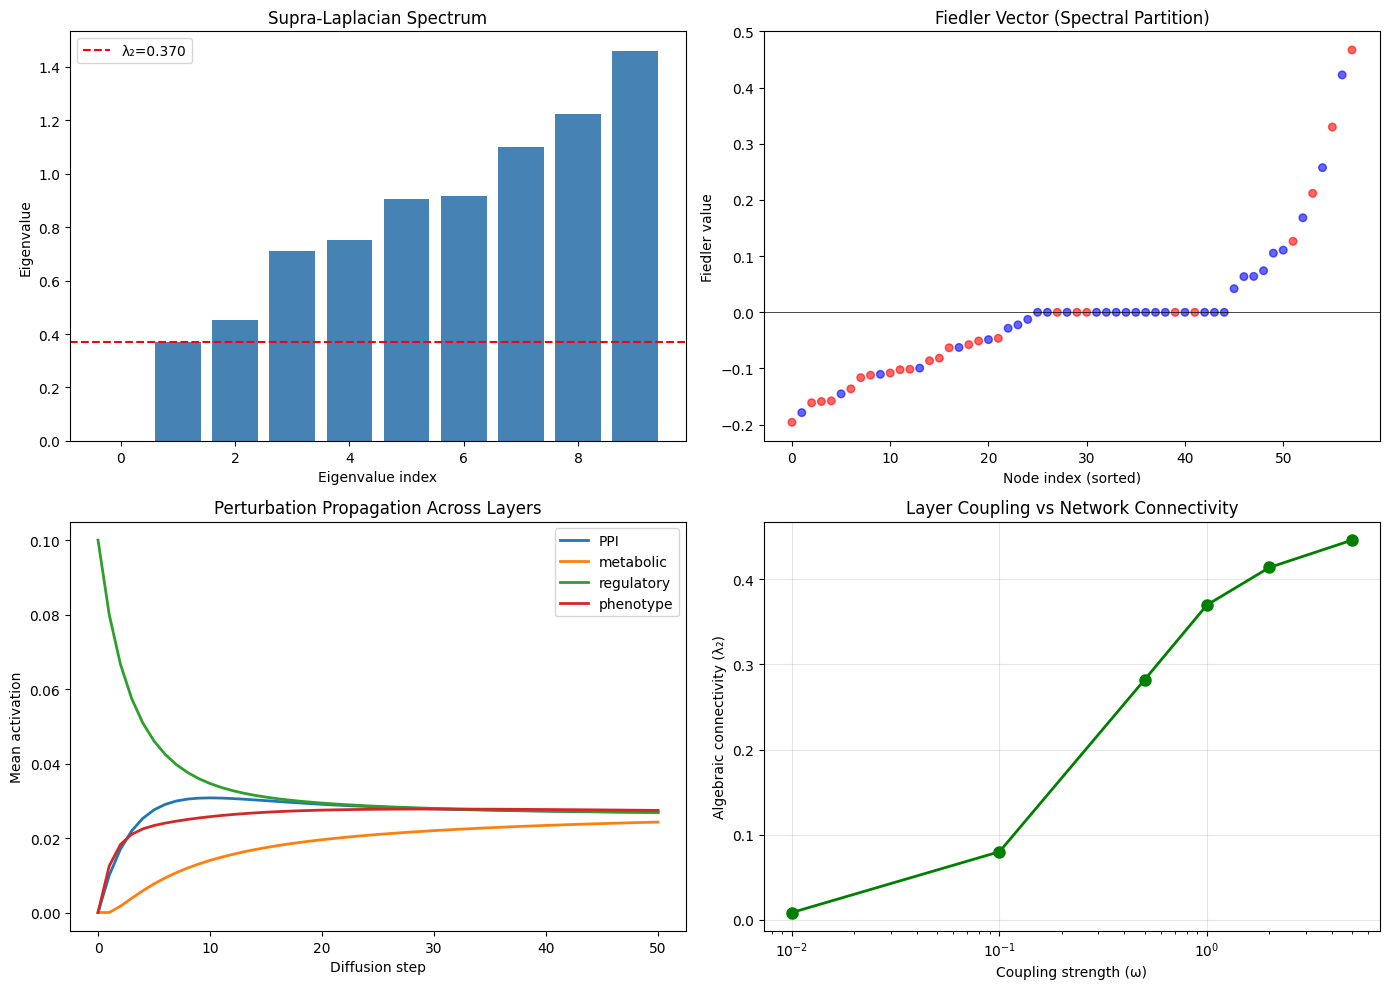

Figure saved to multilayer_analysis.png


In [27]:
# ## 20. Visualization (Optional)

if HAS_MPL:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Eigenvalue spectrum
    ax = axes[0, 0]
    ax.bar(range(len(eigenvalues)), eigenvalues, color='steelblue')
    ax.axhline(y=eigenvalues[1], color='red', linestyle='--', label=f'λ₂={eigenvalues[1]:.3f}')
    ax.set_xlabel('Eigenvalue index')
    ax.set_ylabel('Eigenvalue')
    ax.set_title('Supra-Laplacian Spectrum')
    ax.legend()
    
    # Plot 2: Fiedler vector
    ax = axes[0, 1]
    colors = ['red' if f < 0 else 'blue' for f in fiedler]
    ax.scatter(range(len(fiedler)), np.sort(fiedler), c=colors, alpha=0.6, s=30)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Node index (sorted)')
    ax.set_ylabel('Fiedler value')
    ax.set_title('Fiedler Vector (Spectral Partition)')
    
    # Plot 3: Layer activation over time
    ax = axes[1, 0]
    for L, traj in layer_trajectories.items():
        ax.plot(traj, label=L, linewidth=2)
    ax.set_xlabel('Diffusion step')
    ax.set_ylabel('Mean activation')
    ax.set_title('Perturbation Propagation Across Layers')
    ax.legend()
    
    # Plot 4: Coupling sensitivity
    ax = axes[1, 1]
    omegas = [r["omega"] for r in connectivity_results]
    lambdas = [r["lambda2"] for r in connectivity_results]
    ax.semilogx(omegas, lambdas, 'o-', color='green', linewidth=2, markersize=8)
    ax.set_xlabel('Coupling strength (ω)')
    ax.set_ylabel('Algebraic connectivity (λ₂)')
    ax.set_title('Layer Coupling vs Network Connectivity')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print("Figure saved to multilayer_analysis.png")
else:
    print("Matplotlib not available - skipping visualization")

## Summary
 
 This notebook demonstrated:
 
 1. **Multilayer network construction** with 4 biological layers (PPI, metabolic, regulatory, phenotype)
 
 2. **Kivelä framework** - aspects, elementary layers, vertex-layer presence (V_M)
 
 3. **Intra-layer edges** - interactions within each omic layer
 
 4. **Coupling edges** - same entity across layers (e.g., gene in PPI = gene in regulatory)
 
 5. **Supra-adjacency & supra-Laplacian** - flattened matrix representation
 
 6. **Spectral analysis** - eigenvalues reveal connectivity, Fiedler vector reveals clusters
 
 7. **Diffusion simulation** - perturbation propagation across layers
 
 8. **Coupling sensitivity** - how inter-layer strength affects global properties
 
 9. **Disease module extraction** - identify cross-layer modules connected to phenotypes
 
 10. **Slice integration** - organize results using the graph's slice system
 
### Key Biological Insights
 
 - Genes that are hubs in PPI tend to influence more phenotypes
 - Enzymes bridge PPI and metabolic layers, acting as cross-layer connectors
 - Weak coupling (low ω) means layers evolve independently
 - Strong coupling means perturbations rapidly spread across all layers
 - The Fiedler vector identifies natural boundaries in the disease network